In [1]:
from typing import Annotated
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_core.messages import BaseMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 
from IPython.display import Image
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'ReAct-Agent_v2'

/Users/kmk/Desktop/langchain/langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

In [37]:
from typing import List
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [38]:
class Section(BaseModel):
    name:str=Field(description='Name for this section of the report')
    description:str=Field(description='Brief overview of the main topics and concepts of the section')

class Sections(BaseModel):
    sections:List[Section]=Field(description='Sections of the report')

In [26]:
planner = llm.with_structured_output(Sections)

### Creating Workers Dynamically in Langgraph
- Test1
- Test2

In [39]:
from langgraph.types import Send

class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str
    
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [40]:
def orchestrator(state:State):
    report_sections = planner.invoke(
        SystemMessage(content='Generate a plan for the report.'),
        HumanMessage(content=f'Here is the report topic: {state["topic"]}')
    )
    
    return {'sections': report_sections.sections}

In [41]:
def llm_call(state:WorkerState):
    section = llm.invoke([
        SystemMessage(content='Write a report section following the provided name and description. Include no preamble for each section fetched'),
        HumanMessage(content=f'Here is the section name: {state["section"].name} and description: {state["section"].description}')
    ])
    
    return {'completed_sections' : [section.content]}

In [42]:
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""
    return [Send('llm_call', {'section': s for s in state['sections']})]

In [43]:
def synthesizer(state:State):
    completed_sections = state['completed_sections']
    completed_report_sections = '\n\n--\n\n'.join(completed_sections)
    return {"final_report": completed_report_sections}

In [44]:
orchestrator_work_builder = StateGraph(State)

orchestrator_work_builder.add_node('orchestrator', orchestrator)
orchestrator_work_builder.add_node('llm_call', llm_call)
orchestrator_work_builder.add_node('synthesizer', synthesizer)

orchestrator_work_builder.add_edge(START, 'orchestrator')
orchestrator_work_builder.add_conditional_edges(
    "orchestrator", assign_workers, ['llm_call']
)
orchestrator_work_builder.add_edge('llm_call','synthesizer')
orchestrator_work_builder.add_edge('synthesizer', END)

In [45]:
orchestrator_graph = orchestrator_work_builder.compile()

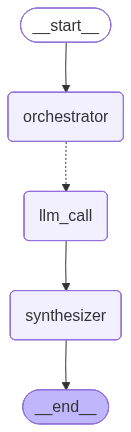

In [46]:
display(Image(orchestrator_graph.get_graph().draw_mermaid_png()))

In [47]:
state = orchestrator_graph.invoke({"topic": "create a report on Agentic AI RAGs"})

AttributeError: 'HumanMessage' object has no attribute 'items'